In [1]:
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input, Embedding, 
from keras.layers import Conv1D, GlobalMaxPool1D, MaxPool1D, LSTM, SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
from classification import *

In [3]:
classification_bow()

BoW results:

             precision    recall  f1-score   support

          1      0.376     0.549     0.446       711
          2      0.210     0.316     0.252       740
          3      0.228     0.367     0.281      1184
          4      0.343     0.402     0.370      3454
          5      0.826     0.671     0.741     10687

avg / total      0.638     0.573     0.598     16776

0.39676162260040143
0.4607718067833824
0.41812108531997183


In [4]:
classification_with_aspects()

aspects results:

             precision    recall  f1-score   support

          1      0.113     0.654     0.193       711
          2      0.084     0.134     0.104       740
          3      0.120     0.112     0.116      1184
          4      0.284     0.324     0.303      3454
          5      0.759     0.458     0.571     10687

avg / total      0.559     0.400     0.447     16776

0.2721458705950493
0.3364462020635144
0.2573202077133035


In [5]:
data = load_texts()
data2 = np.array(load_weights())
labels = load_rating()
train_length = int(len(data) * 0.8)

x_train = data[:train_length]
y_train = labels[:train_length]
x2_train = data2[:train_length]
x_test = data[train_length:]
y_test = labels[train_length:]
x2_text = data2[train_length:]

In [6]:
lens = [len(str.split(x)) for x in data]

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

(array([8.2236e+04, 1.4220e+03, 1.6900e+02, 2.5000e+01, 1.0000e+01,
        8.0000e+00, 1.0000e+00, 4.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  11.,  355.,  699., 1043., 1387., 1731., 2075., 2419., 2763.,
        3107., 3451.]),
 <a list of 10 Patch objects>)

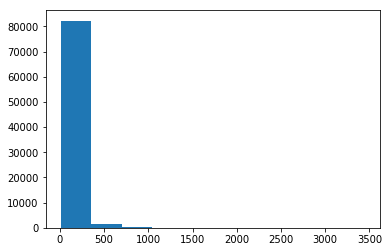

In [8]:
plt.hist(lens)

In [9]:
max_words = 2**17
batch_size = 512
max_len = 256

In [10]:
print("Preparing the Tokenizer...")
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)

Preparing the Tokenizer...


In [11]:
print('Vectorizing sequence data...')
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)


Vectorizing sequence data...


In [12]:
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

In [13]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (67101, 256)
x_test shape: (16776, 256)


In [14]:
x_train

array([[   0,    0,    0, ...,   16, 1138,  214],
       [   0,    0,    0, ..., 1036, 2318, 3509],
       [   0,    0,    0, ...,  912, 3202, 6288],
       ...,
       [   0,    0,    0, ...,    3,    2,  487],
       [   0,    0,    0, ...,   16,  426, 1095],
       [   0,    0,    0, ..., 1671,  551,   57]], dtype=int32)

In [15]:
print('Convert class vector to binary class matrix '
      '(for use with categorical_crossentropy)')
num_classes = 5
y_train = keras.utils.to_categorical([y-1 for y in y_train], num_classes)
y_val = keras.utils.to_categorical([y-1 for y in y_test], num_classes)
print('y_train shape:', y_train.shape)
print('y_val shape:', y_val.shape)

Convert class vector to binary class matrix (for use with categorical_crossentropy)
y_train shape: (67101, 5)
y_val shape: (16776, 5)


In [16]:
y_val

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [52]:
main_input = Input(shape=(max_len,), dtype='int32', name='main_input')
emb = Embedding(output_dim=128, input_dim=max_words, input_length=max_len)(main_input)
emb = SpatialDropout1D(0.1)(emb)

# tower_1 = Conv1D(64, 1, padding='same', activation='relu')(emb)
tower_1 = Conv1D(256, 3, padding='valid', activation='relu')(emb)
#tower_1 = LSTM(128)(tower_1)
tower_1 = SpatialDropout1D(0.1)(tower_1)
tower_1 = GlobalMaxPool1D()(tower_1)

# tower_2 = Conv1D(64, 1, padding='same', activation='relu')(emb)
tower_2 = Conv1D(256, 5, padding='valid', activation='relu')(emb)
#tower_2 = LSTM(128)(tower_2)
tower_2 = SpatialDropout1D(0.1)(tower_2)
tower_2 = GlobalMaxPool1D()(tower_2)

# tower_3 = MaxPool1D(3, padding='same')(emb)
tower_3 = Conv1D(256, 7, padding='valid', activation='relu')(emb)
#tower_3 = LSTM(128)(tower_3)
tower_3 = SpatialDropout1D(0.1)(tower_3)
tower_3 = GlobalMaxPool1D()(tower_3)

aux_input = Input(shape=(50,), dtype='float', name='aux_input')
output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=1)
# output = Dropout(0.1)(output)
output = keras.layers.concatenate([output, aux_input], axis=1)
sm = Dense(num_classes, activation='softmax')(output)

model = Model(inputs=[main_input, aux_input], outputs=sm)

In [53]:
model.layers

In [54]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

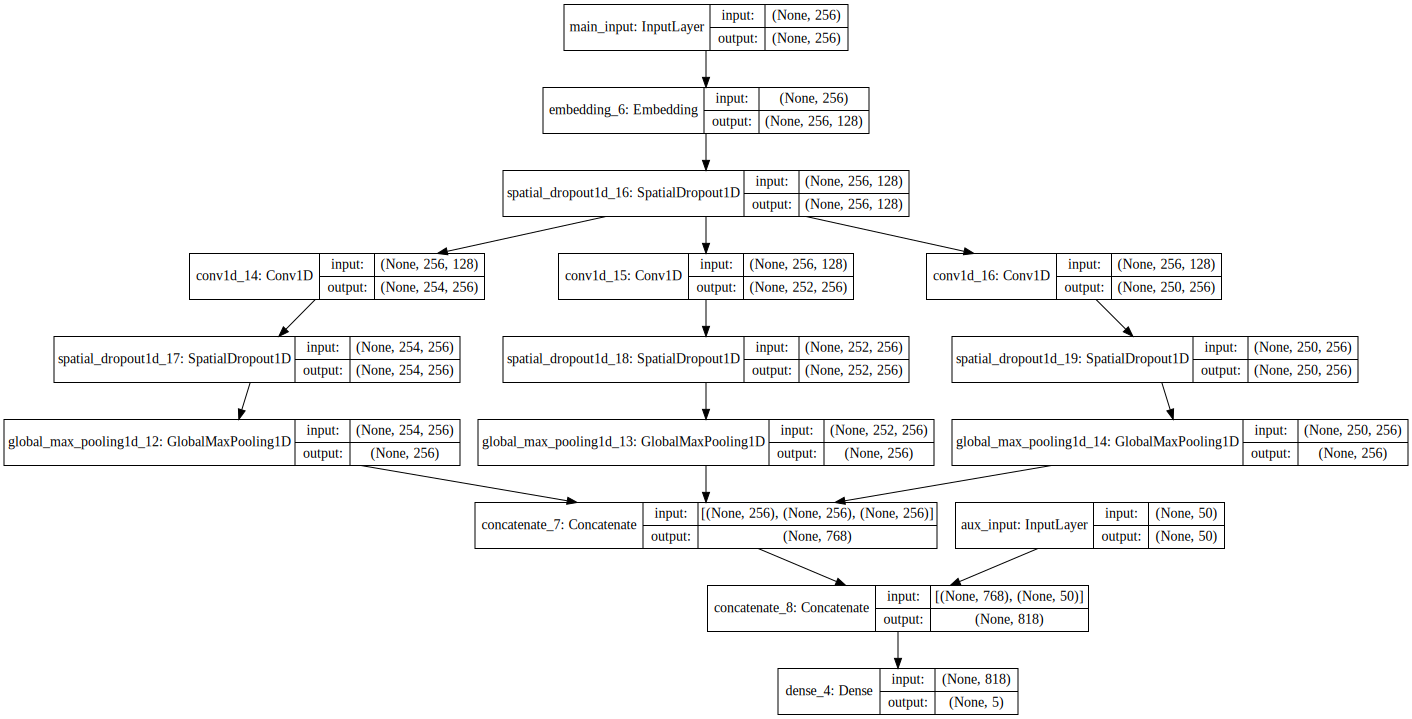

In [55]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [56]:
from keras.objectives import categorical_crossentropy
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['categorical_accuracy'])

In [57]:
epochs = 10

In [58]:
from keras.callbacks import TensorBoard  
tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
from keras.callbacks import EarlyStopping  
early_stopping=EarlyStopping(monitor='val_loss', patience=3)  


history = model.fit([x_train, x2_train], y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[tensorboard, early_stopping])

Train on 60390 samples, validate on 6711 samples
Epoch 1/10
16896/60390 [=======>......................] - ETA: 9s - loss: 1.1358 - categorical_accuracy: 0.6179

KeyboardInterrupt: 

In [59]:
from keras.callbacks import TensorBoard  
tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
from keras.callbacks import EarlyStopping  
early_stopping=EarlyStopping(monitor='val_loss', patience=3)  


history = model.fit([x_train, np.zeros_like(x2_train)], y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[tensorboard, early_stopping])

Train on 60390 samples, validate on 6711 samples
Epoch 1/10
60390/60390 [==============================] - 13s 223us/step - loss: 0.9090 - categorical_accuracy: 0.6434 - val_loss: 0.8086 - val_categorical_accuracy: 0.6683
Epoch 2/10
60390/60390 [==============================] - 14s 224us/step - loss: 0.7294 - categorical_accuracy: 0.7001 - val_loss: 0.7758 - val_categorical_accuracy: 0.6865
Epoch 3/10
60390/60390 [==============================] - 14s 224us/step - loss: 0.5920 - categorical_accuracy: 0.7631 - val_loss: 0.8221 - val_categorical_accuracy: 0.6580
Epoch 4/10
60390/60390 [==============================] - 14s 224us/step - loss: 0.4266 - categorical_accuracy: 0.8423 - val_loss: 0.9425 - val_categorical_accuracy: 0.6561
Epoch 5/10
60390/60390 [==============================] - 14s 226us/step - loss: 0.2713 - categorical_accuracy: 0.9094 - val_loss: 1.1469 - val_categorical_accuracy: 0.6410


In [60]:
score = model.evaluate([x_test, x2_text], y_val, batch_size=batch_size, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

16776/16776 [==============================] - 1s 47us/step


Test score: 1.1658225795969146
Test accuracy: 0.6406175482824523


In [61]:
results = model.predict([x_test, x2_text], batch_size=batch_size, verbose=1)

16776/16776 [==============================] - 1s 51us/step


In [62]:
results = model.predict([x_test, np.zeros_like(x2_text)], batch_size=batch_size, verbose=1)

16776/16776 [==============================] - 1s 46us/step


In [63]:
print(classification_report(y_val, np.round(results), digits=3))

             precision    recall  f1-score   support

          0      0.603     0.404     0.484       711
          1      0.349     0.157     0.216       740
          2      0.484     0.125     0.199      1184
          3      0.346     0.271     0.304      3454
          4      0.758     0.830     0.793     10687

avg / total      0.629     0.618     0.612     16776



In [50]:
print(metrics.precision_score(y_val, np.round(results), average='macro'))
print(metrics.recall_score(y_val, np.round(results), average='macro'))
print(metrics.f1_score(y_val, np.round(results), average='macro'))

0.504936852299697
0.35724086764457663
0.40244854506162275
